In [1]:
%matplotlib inline
import sys
print('Python Version: {}'.format(sys.version))

import pandas as pd
print('pandas version: {}'.format(pd.__version__))

import matplotlib
print('matplotlib version: {}'.format(matplotlib.__version__))

import numpy as np
print('numpy version: {}'.format(np.__version__))

import scipy as sp
print('scipy version: {}'.format(sp.__version__))

import IPython
print('ipython version: {}'.format(IPython.__version__))

import sklearn
print('scikit-learn version: {}'.format(sklearn.__version__))

import matplotlib.pyplot as plt

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
matplotlib.rcParams['axes.unicode_minus'] = False

# 한글 폰트 설정
plt.rcParams["font.family"] = 'AppleGothic'

import mglearn

from IPython.display import display

Python Version: 3.5.3 |Anaconda custom (x86_64)| (default, Mar  6 2017, 12:15:08) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
pandas version: 0.20.3
matplotlib version: 2.0.2
numpy version: 1.13.1
scipy version: 0.19.1
ipython version: 6.0.0
scikit-learn version: 0.19.0


In [2]:
citibike = mglearn.datasets.load_citibike()
print('시티바이크 데이터:\n{}'.format(citibike.head()))

시티바이크 데이터:
starttime
2015-08-01 00:00:00     3.0
2015-08-01 03:00:00     0.0
2015-08-01 06:00:00     9.0
2015-08-01 09:00:00    41.0
2015-08-01 12:00:00    39.0
Freq: 3H, Name: one, dtype: float64


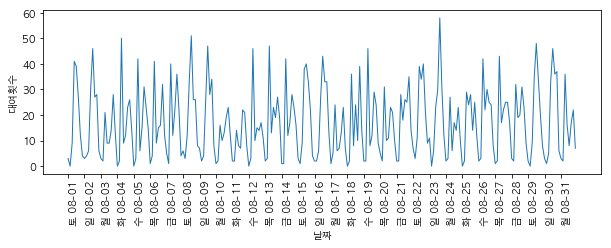

In [4]:
plt.figure(figsize=(10, 3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(), freq='D')
week = ['일','월','화','수','목','금','토']
xticks_name = [week[int(w)]+d for w, d in zip(xticks.strftime('%w'), xticks.strftime(' %m-%d'))]
plt.xticks(xticks, xticks_name, rotation=90, ha='left')
plt.plot(citibike, linewidth=1)
plt.xlabel('날짜')
plt.ylabel('대여횟수')

In [5]:
y = citibike.values
X = citibike.index.astype('int64').values.reshape(-1, 1) // 10**9

In [11]:
n_train = 184

def eval_on_features(features, target, regressor):
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print('테스트 세트 R^2: {:.3f}'.format(regressor.score(X_test, y_test)))
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    
    plt.figure(figsize=(10, 3))
    plt.xticks(range(0, len(X), 8), xticks_name, rotation=90, ha='left')
    plt.plot(range(n_train), y_train, label='훈련')
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label='테스트')
    plt.plot(range(n_train), y_pred_train, '--', label='훈련 예측')
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '-.', label='테스트 예측')
    plt.legend(loc=(1.01, 0))
    plt.xlabel('날짜')
    plt.ylabel('대여횟수')

테스트 세트 R^2: -0.035


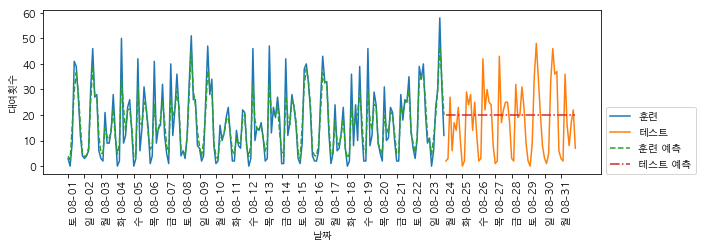

In [12]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X, y, regressor)

테스트 세트 R^2: 0.600


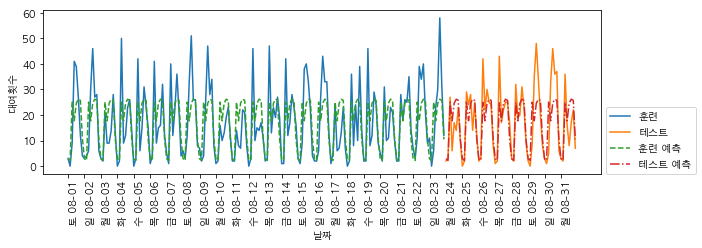

In [13]:
X_hour = citibike.index.hour.values.reshape(-1, 1)
eval_on_features(X_hour, y, regressor)

테스트 세트 R^2: 0.842


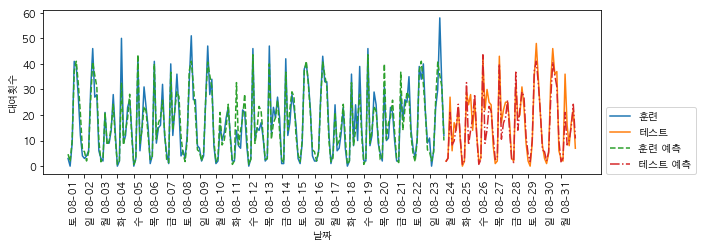

In [14]:
X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1, 1),
                        citibike.index.hour.values.reshape(-1, 1)])
eval_on_features(X_hour_week, y, regressor)

테스트 세트 R^2: 0.132


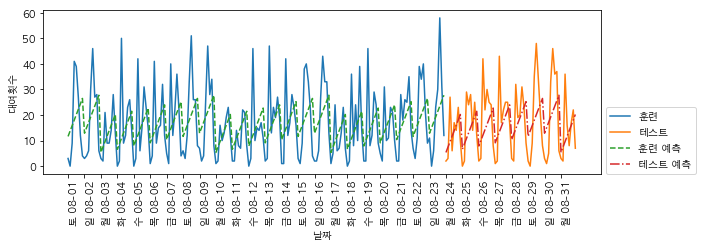

In [15]:
from sklearn.linear_model import LinearRegression

eval_on_features(X_hour_week, y, LinearRegression())

테스트 세트 R^2: 0.619


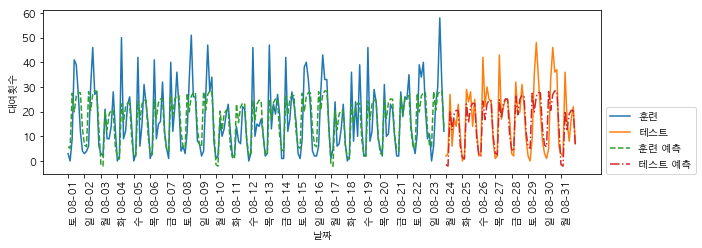

In [18]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge

enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()
eval_on_features(X_hour_week_onehot, y, Ridge())

테스트 세트 R^2: 0.845


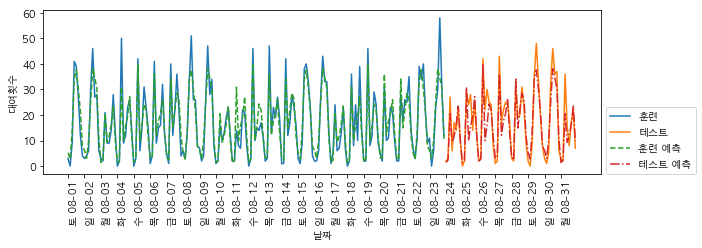

In [21]:
from sklearn.preprocessing import PolynomialFeatures

poly_transformer = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)
lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr)

In [23]:
hour = ['%02d:00' % i for i in range(0, 24, 3)]
day = ['월','화','수','목','금','토','일']
features = day + hour

In [26]:
features_poly = poly_transformer.get_feature_names(features)
features_nonzero = np.array(features_poly)[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_ != 0]

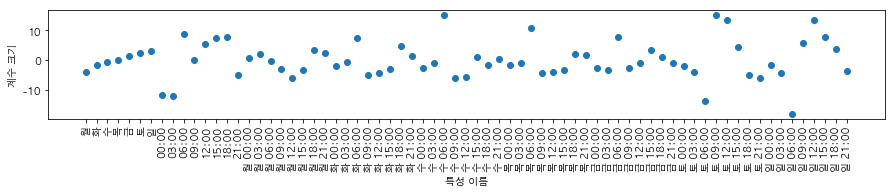

In [27]:
plt.figure(figsize=(15, 2))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90)
plt.xlabel('특성 이름')
plt.ylabel('계수 크기')